In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
pd.set_option('display.max_columns', 500)
from pygam import LinearGAM
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from datetime import datetime
import pickle
import seaborn as sns
import plotly.graph_objects as go
import json

Stations:
Toronto : 31688
Ottawa : 30578
Windsor : 4716, 52838, 54738

for year in `seq 2002 2019`;do for month in `seq 1 12`;do wget --content-disposition "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=31688&Year=${year}&Month=${month}&Day=14&timeframe=1&submit=Download+Data" ;done;done

In [2]:
data_sources = listdir('data/Demand')
toronto_weather_files = listdir('data/Toronto')
ottawa_weather_files = listdir('data/Ottawa')
windsor_weather_files = []
for x in listdir('data/Windsor'):
    windsor_weather_files.append([f'{x}/{y}' for y in listdir(f'data/Windsor/{x}')])
windsor_weather_files = [x for x in windsor_weather_files for x in x]

In [3]:
data = pd.DataFrame()
for x in data_sources:
    df = pd.read_csv(f'data/Demand/{x}', skiprows=3, parse_dates=[0])
    data = pd.concat([data,df], sort=True)

In [4]:
toronto_weather = pd.DataFrame()
for x in toronto_weather_files:
    df = pd.read_csv(f'data/Toronto/{x}', skiprows=15, parse_dates=[0])
    toronto_weather = pd.concat([toronto_weather,df], sort=True)

In [5]:
ottawa_weather = pd.DataFrame()
for x in ottawa_weather_files:
    df = pd.read_csv(f'data/Ottawa/{x}', skiprows=15, parse_dates=[0])
    ottawa_weather = pd.concat([ottawa_weather,df], sort=True)

In [6]:
windsor_weather = pd.DataFrame()
for x in windsor_weather_files:
    df = pd.read_csv(f'data/Windsor/{x}', skiprows=15, parse_dates=[0])
    windsor_weather = pd.concat([windsor_weather,df], sort=True)

In [7]:
ottawa_weather.head(1)

,Date/Time,Day,Dew Point Temp (°C),Dew Point Temp Flag,Hmdx,Hmdx Flag,Month,Rel Hum (%),Rel Hum Flag,Stn Press (kPa),Stn Press Flag,Temp (°C),Temp Flag,Time,Visibility (km),Visibility Flag,Weather,Wind Chill,Wind Chill Flag,Wind Dir (10s deg),Wind Dir Flag,Wind Spd (km/h),Wind Spd Flag,Year
0,2002-01-01,1,-12.9,NaN,NaN,NaN,1,83.0,NaN,NaN,M,-10.6,NaN,00:00,NaN,M,NaN,-16.0,NaN,28.0,NaN,9.0,NaN,2002


In [8]:
len(toronto_weather)

157776

In [9]:
len(ottawa_weather)

157776

In [10]:
len(windsor_weather)

175296

In [11]:
toronto_weather.head()

,Date/Time,Day,Dew Point Temp (°C),Dew Point Temp Flag,Hmdx,Hmdx Flag,Month,Rel Hum (%),Rel Hum Flag,Stn Press (kPa),Stn Press Flag,Temp (°C),Temp Flag,Time,Visibility (km),Visibility Flag,Weather,Wind Chill,Wind Chill Flag,Wind Dir (10s deg),Wind Dir Flag,Wind Spd (km/h),Wind Spd Flag,Year
0,2002-01-01 00:00:00,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002
1,2002-01-01 01:00:00,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002
2,2002-01-01 02:00:00,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002
3,2002-01-01 03:00:00,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002
4,2002-01-01 04:00:00,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002


In [12]:
toronto_weather = toronto_weather.dropna(subset=['Temp (°C)'])
ottawa_weather = ottawa_weather.dropna(subset=['Temp (°C)'])
windsor_weather = windsor_weather.dropna(subset=['Temp (°C)'])

In [13]:
toronto_weather.head(10)

,Date/Time,Day,Dew Point Temp (°C),Dew Point Temp Flag,Hmdx,Hmdx Flag,Month,Rel Hum (%),Rel Hum Flag,Stn Press (kPa),Stn Press Flag,Temp (°C),Temp Flag,Time,Visibility (km),Visibility Flag,Weather,Wind Chill,Wind Chill Flag,Wind Dir (10s deg),Wind Dir Flag,Wind Spd (km/h),Wind Spd Flag,Year
0,2003-01-01 00:00:00,1,-3.9,NaN,NaN,NaN,1,68.0,NaN,100.18,NaN,1.4,NaN,00:00,NaN,M,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2003
1,2003-01-01 01:00:00,1,-4.4,NaN,NaN,NaN,1,65.0,NaN,100.23,NaN,1.5,NaN,01:00,NaN,M,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2003
2,2003-01-01 02:00:00,1,-4.2,NaN,NaN,NaN,1,66.0,NaN,100.32,NaN,1.5,NaN,02:00,NaN,M,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2003
3,2003-01-01 03:00:00,1,-4.7,NaN,NaN,NaN,1,66.0,NaN,100.36,NaN,1.0,NaN,03:00,NaN,M,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2003
4,2003-01-01 04:00:00,1,-5.2,NaN,NaN,NaN,1,65.0,NaN,100.43,NaN,0.7,NaN,04:00,NaN,M,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2003
6,2003-01-01 06:00:00,1,-5.4,NaN,NaN,NaN,1,66.0,NaN,100.44,NaN,0.3,NaN,06:00,NaN,M,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2003
7,2003-01-01 07:00:00,1,-5.5,NaN,NaN,NaN,1,66.0,NaN,100.44,NaN,0.0,NaN,07:00,NaN,M,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2003
8,2003-01-01 08:00:00,1,-5.1,NaN,NaN,NaN,1,68.0,NaN,100.44,NaN,0.0,NaN,08:00,NaN,M,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2003
9,2003-01-01 09:00:00,1,-5.1,NaN,NaN,NaN,1,68.0,NaN,100.45,NaN,0.0,NaN,09:00,NaN,M,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2003
10,2003-01-01 10:00:00,1,-6.1,NaN,NaN,NaN,1,64.0,NaN,100.57,NaN,-0.2,NaN,10:00,NaN,M,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2003


In [14]:
toronto_weather['Hour'] = toronto_weather['Date/Time'].dt.hour
ottawa_weather['Hour'] = ottawa_weather['Date/Time'].dt.hour
windsor_weather['Hour'] = windsor_weather['Date/Time'].dt.hour

In [15]:
len(toronto_weather)

149511

In [16]:
len(ottawa_weather)

153593

In [17]:
len(windsor_weather)

155161

In [18]:
data.head(1)

,Date,Hour,Market Demand,Ontario Demand
0,2014-01-01,1,18266,15862


In [19]:
toronto_weather_compressed = toronto_weather[['Date/Time', 'Day', 'Month', 'Year', 'Hour', 'Temp (°C)', 'Rel Hum (%)']]
ottawa_weather_compressed = ottawa_weather[['Date/Time', 'Day', 'Month', 'Year', 'Hour', 'Temp (°C)', 'Rel Hum (%)']]
windsor_weather_compressed = windsor_weather[['Date/Time', 'Day', 'Month', 'Year', 'Hour', 'Temp (°C)', 'Rel Hum (%)']]

In [20]:
data['Date/Time'] = data.Date + pd.to_timedelta(data.Hour, unit= 'h')

In [21]:
len(data)

50040

In [22]:
data = data.set_index('Date/Time').join(toronto_weather_compressed[['Date/Time', 'Temp (°C)', 'Rel Hum (%)']].set_index('Date/Time'))
data = data.rename(columns={'Temp (°C)' : 'toronto_temp', 'Rel Hum (%)':'toronto_humid'})
data = data.join(ottawa_weather_compressed[['Date/Time', 'Temp (°C)','Rel Hum (%)']].set_index('Date/Time'))
data = data.rename(columns={'Temp (°C)' : 'ottawa_temp', 'Rel Hum (%)':'ottawa_humid'})
data = data.join(windsor_weather_compressed[['Date/Time', 'Temp (°C)','Rel Hum (%)']].set_index('Date/Time'))
data = data.rename(columns={'Temp (°C)' : 'windsor_temp', 'Rel Hum (%)':'windsor_humid'})

In [23]:
data.head()

,Date,Hour,Market Demand,Ontario Demand,toronto_temp,toronto_humid,ottawa_temp,ottawa_humid,windsor_temp,windsor_humid
Date/Time,,,,,,,,,,
2014-01-01 01:00:00,2014-01-01,1,18266,15862,-8.7,59.0,-18.7,89.0,-8.8,90.0
2014-01-01 02:00:00,2014-01-01,2,17705,15462,-9.0,62.0,-19.9,87.0,-8.6,87.0
2014-01-01 03:00:00,2014-01-01,3,17582,15182,-9.6,65.0,-18.7,88.0,-8.5,87.0
2014-01-01 04:00:00,2014-01-01,4,17311,14925,-9.7,67.0,-20.4,86.0,-8.4,84.0
2014-01-01 05:00:00,2014-01-01,5,17090,14807,-9.6,70.0,-20.2,85.0,-9.2,87.0


In [24]:
data.dtypes

Date              datetime64[ns]
Hour                       int64
Market Demand              int64
Ontario Demand             int64
toronto_temp             float64
toronto_humid            float64
ottawa_temp              float64
ottawa_humid             float64
windsor_temp             float64
windsor_humid            float64
dtype: object

In [25]:
data['dow'] = data.Date.dt.dayofweek
data['month'] = data.Date.dt.month
data['week'] = data.Date.dt.week

In [26]:
small_data = data.iloc[0:500,:]

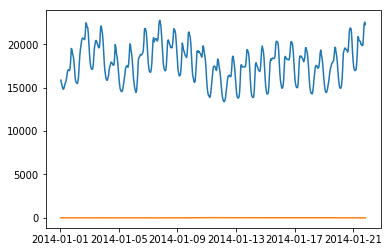

In [27]:
plt.plot(small_data.index, small_data[['Ontario Demand', 'toronto_temp']])
plt.show()

In [28]:
data.head(1)

,Date,Hour,Market Demand,Ontario Demand,toronto_temp,toronto_humid,ottawa_temp,ottawa_humid,windsor_temp,windsor_humid,dow,month,week
Date/Time,,,,,,,,,,,,,
2014-01-01 01:00:00,2014-01-01,1,18266,15862,-8.7,59.0,-18.7,89.0,-8.8,90.0,2,1,1


In [29]:
data.toronto_temp.fillna(method='ffill', inplace=True)
data.ottawa_temp.fillna(method='ffill', inplace=True)
data.windsor_temp.fillna(method='ffill', inplace=True)
data.toronto_humid.fillna(method='ffill', inplace=True)
data.ottawa_humid.fillna(method='ffill', inplace=True)
data.windsor_humid.fillna(method='ffill', inplace=True)

In [30]:
data.head(1)

,Date,Hour,Market Demand,Ontario Demand,toronto_temp,toronto_humid,ottawa_temp,ottawa_humid,windsor_temp,windsor_humid,dow,month,week
Date/Time,,,,,,,,,,,,,
2014-01-01 01:00:00,2014-01-01,1,18266,15862,-8.7,59.0,-18.7,89.0,-8.8,90.0,2,1,1


In [31]:
data[-100:]

,Date,Hour,Market Demand,Ontario Demand,toronto_temp,toronto_humid,ottawa_temp,ottawa_humid,windsor_temp,windsor_humid,dow,month,week
Date/Time,,,,,,,,,,,,,
2019-09-12 21:00:00,2019-09-12,21,17994,15747,17.0,70.0,13.4,58.0,17.3,95.0,3,9,37
2019-09-12 22:00:00,2019-09-12,22,16845,14667,16.5,75.0,11.5,66.0,17.3,92.0,3,9,37
2019-09-12 23:00:00,2019-09-12,23,15516,13371,16.5,69.0,9.6,79.0,17.3,88.0,3,9,37
2019-09-13 00:00:00,2019-09-12,24,14792,12433,15.8,68.0,10.7,70.0,17.5,86.0,3,9,37
2019-09-13 01:00:00,2019-09-13,1,14461,11744,17.0,57.0,10.1,74.0,17.4,88.0,4,9,37
2019-09-13 02:00:00,2019-09-13,2,14238,11435,17.3,58.0,9.2,77.0,17.0,91.0,4,9,37
2019-09-13 03:00:00,2019-09-13,3,14134,11365,15.7,71.0,8.7,80.0,17.4,90.0,4,9,37
2019-09-13 04:00:00,2019-09-13,4,14383,11559,16.4,67.0,7.7,84.0,17.6,94.0,4,9,37
2019-09-13 05:00:00,2019-09-13,5,14661,11907,16.2,71.0,6.8,86.0,18.0,96.0,4,9,37


In [32]:
len(data)

50092

In [33]:
x_train = data.iloc[0:50000, [1,4,6,8,10,12]]
y_train = data.iloc[:50000, [3]]

In [34]:
x_test = data.iloc[20000:50092, [1,4,6,8,10,12]]
y_test = data.iloc[20000:50092, [3]]

In [35]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [36]:
views = 200

In [37]:
gam = LinearGAM()

In [38]:
gam.fit(x_train, y_train)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + intercept, 
   tol=0.0001, verbose=False)

In [40]:
with open('model','wb') as p:
    pickle.dump(gam,p)

In [41]:
gam_predict = gam.predict(x_train)

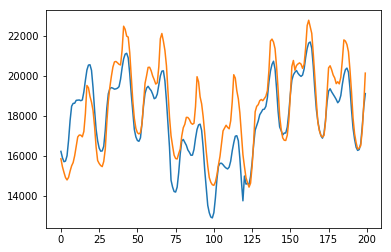

In [42]:
plt.plot(range(views), gam_predict[:views],  y_train[:views])

In [43]:
test_gam_predict = gam.predict(x_test)

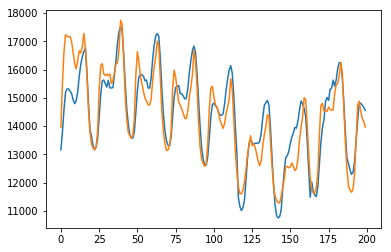

In [44]:
plt.plot(range(views), test_gam_predict[:views],  y_test[:views])

In [45]:
gam_train_score = r2_score(y_train,gam_predict)

In [46]:
gam_test_score = r2_score(y_test, test_gam_predict)

In [47]:
gam_test_score

0.8864625776280992

In [48]:
gam_train_score

0.8845811026521757

In [57]:
sns.set_style('darkgrid')

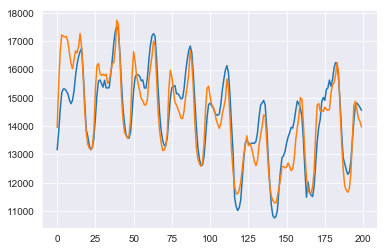

In [58]:
plt.plot(range(views), test_gam_predict[:views],  y_test[:views])